In [1]:
import os, shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms.v2.functional as F_v2
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from Methods.HEPA.model import HEPA


In [2]:
def get_optimiser(model, optimiser, lr, wd, exclude_bias=True, exclude_bn=True, momentum=0.9, betas=(0.9, 0.999)):
    non_decay_parameters = []
    decay_parameters = []   
    for n, p in model.named_parameters():
        if exclude_bias and 'bias' in n:
            non_decay_parameters.append(p)
        elif exclude_bn and 'bn' in n:
            non_decay_parameters.append(p)
        else:
            decay_parameters.append(p)
    non_decay_parameters = [{'params': non_decay_parameters, 'weight_decay': 0.0}]
    decay_parameters = [{'params': decay_parameters}]

    assert optimiser in ['AdamW', 'SGD'], 'optimiser must be one of ["AdamW", "SGD"]'
    if optimiser == 'AdamW':
        if momentum != 0.9:
            print('Warning: AdamW does not accept momentum parameter. Ignoring it. Please specify betas instead.')
        optimiser = torch.optim.AdamW(decay_parameters + non_decay_parameters, lr=lr, weight_decay=wd, betas=betas)
    elif optimiser == 'SGD':
        if betas != (0.9, 0.999):
            print('Warning: SGD does not accept betas parameter. Ignoring it. Please specify momentum instead.')
        optimiser = torch.optim.SGD(decay_parameters + non_decay_parameters, lr=lr, weight_decay=wd, momentum=momentum)
    
    return optimiser

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
device

device(type='cuda')

In [4]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Pad(2),
    # transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Pad(2),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])

augmentation = transforms.Compose([
    transforms.RandomCrop(20),
    transforms.Resize(28, interpolation=transforms.InterpolationMode.NEAREST),
    # transforms.RandomAffine(degrees=180, translate=(0.28, 0.28), scale=(0.75, 1.25), shear=25),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.75, 1.25), shear=25),
    # transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)

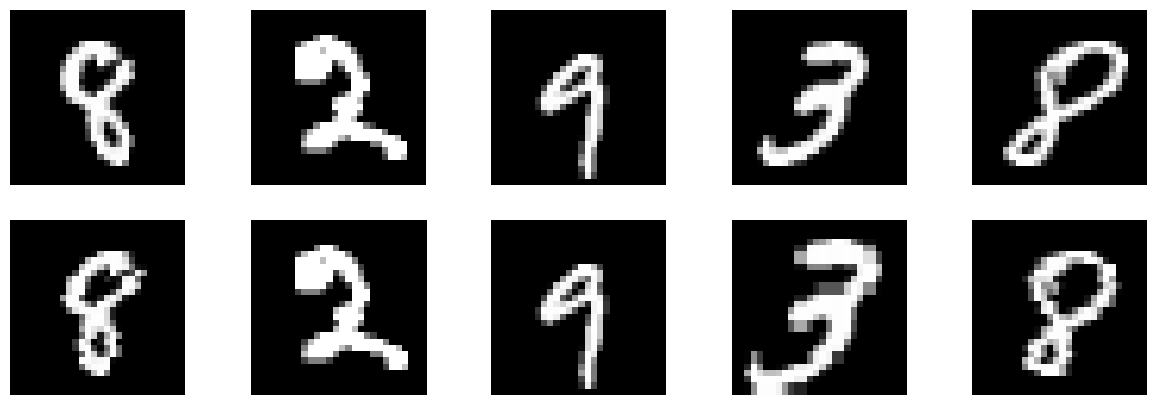

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [5]:
# Show example images
# fig, axes = plt.subplots(1, 10, figsize=(15,5))
# for i, ax in enumerate(axes):
#     img, label = train_set[i]
#     angle = torch.rand(1).item() * 360 - 180 if torch.rand(1).item() > 0.75 else 0
#     translate_x = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
#     translate_y = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
#     scale = torch.rand(1).item() * 0.5 + 0.75 if torch.rand(1).item() > 0.75 else 1.0
#     shear = torch.rand(1).item() * 50 - 25 if torch.rand(1).item() > 0.75 else 0
#     img = F_v2.affine(img, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=shear)
#     ax.imshow(img.squeeze().cpu(), cmap='gray')
#     ax.set_title(f"Label: {label}")
#     ax.axis('off')
# plt.show()

# show before and after on each row
fig, axes = plt.subplots(2, 5, figsize=(15,5))
for i, ax in enumerate(axes[0]):
    img, label = train_set[i+20]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    img, label = train_set[i+20]
    angle = torch.rand(1).item() * 360 - 180 if torch.rand(1).item() > 0.75 else 0
    translate_x = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
    translate_y = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
    scale = torch.rand(1).item() * 0.5 + 0.75 if torch.rand(1).item() > 0.75 else 1.0
    shear = torch.rand(1).item() * 50 - 25 if torch.rand(1).item() > 0.75 else 0
    img = F_v2.affine(img, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=shear)
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()



# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

train_dataset transform: Compose(
)


Epoch: 10 - Train Loss: 0.0688 - LR: 0.0003 - WD: 0.0411


Epoch: 20 - Train Loss: 0.0456 - LR: 0.0003 - WD: 0.0451


Epoch: 30 - Train Loss: 0.0384 - LR: 0.0003 - WD: 0.0518


Epoch: 40 - Train Loss: 0.0331 - LR: 0.0003 - WD: 0.0612


Epoch: 50 - Train Loss: 0.0319 - LR: 0.0003 - WD: 0.0731


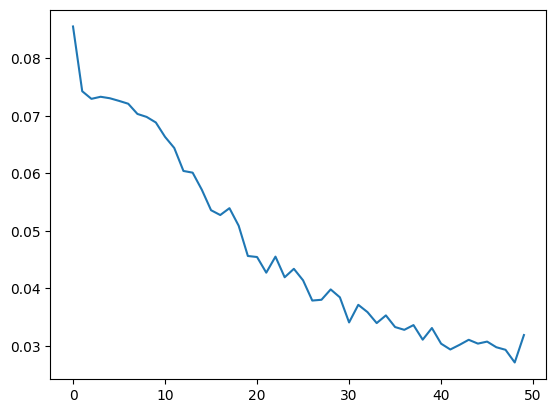

In [6]:
from Methods.HEPA.train_basic import train as train_hepa_basic
from Models import iGPA
from Utils.utils import get_optimiser
from Utils.train_min import train

model = iGPA(1, 5).to(device)
# optimiser = get_optimiser(
#     model, 
#     'AdamW', 
#     lr=3e-4, 
#     wd=0.004, 
#     exclude_bias=True,
#     exclude_bn=True,
# )
cfg = {
    'optimiser': 'AdamW',
    'exclude_bias': True,
    'exclude_bn': True,
    'betas': (0.9, 0.999),
    'momentum': 0.9,
}
optimiser = get_optimiser(model, cfg)
train_set.transform = transforms.Compose([
])
train_losses = train_hepa_basic(
    model,
    optimiser,
    train_set,
    val_set,
    num_epochs=250,
    batch_size=256,
    stop_at=0,
    train_aug_scaler='none',
    val_aug_scaler='none',
    loss_fn='mse',
    learn_on_ss=False,
    writer=None,
    save_dir=None,
    save_every=5,
)
# train_cfg = {
#     'device': 'cuda',
#     'ddp_rank': 0,
#     'warmup': 10,
#     'flat': 0,
#     'num_epochs': 250,
#     'batch_size': 256,
#     'start_lr': 3e-4,
#     'end_lr': 1e-6,
#     'start_wd': 0.04,
#     'end_wd': 0.4,
#     'decay_lr': True,
#     'master_process': True,
#     'local': True,
#     'dataset': 'mnist',
# }
# train_losses = train(model, optimiser, train_set, train_cfg)

plt.plot(train_losses)
plt.show()

In [6]:
from Methods.HEPA.train_basic import train as train_hepa_basic
from Models import iGPA
from Utils.utils import get_optimiser
from Utils.train_min import train

model = iGPA(1, 5).to(device)
opt_cfg = {
    'optimiser': 'AdamW',
    'exclude_bias': True,
    'exclude_bn': True,
    'betas': (0.9, 0.999),
    'momentum': 0.9,
}
optimiser = get_optimiser(model, opt_cfg)
train_cfg = {
    'device': 'cuda',
    'ddp_rank': 0,
    'warmup': 10,
    'flat': 0,
    'num_epochs': 250,
    'batch_size': 256,
    'start_lr': 3e-4,
    'end_lr': 1e-6,
    'start_wd': 0.04,
    'end_wd': 0.4,
    'decay_lr': True,
    'master_process': True,
    'local': True,
    'dataset': 'mnist',
}
train_losses = train(model, optimiser, train_set, train_cfg)

plt.plot(train_losses)
plt.show()

Epoch: 10 - Train Loss: 0.0669 - LR: 0.0003 - WD: 0.0411


Epoch: 20 - Train Loss: 0.0445 - LR: 0.0003 - WD: 0.0451


KeyboardInterrupt: 

In [5]:
cfgs = [
    {
        'name': 'BYOL'
    },
]

for cfg in cfgs:

    Model = BYOL
    backbone = 'mnist_cnn'
    experiment_name = cfg['name']
    # experiment = 'mnist_byol'
    experiment= 'compare'
    log_dir = f'Examples/MNIST/out/logs/{experiment}/{experiment_name}/'
    save_dir = f'Examples/MNIST/out/models/{experiment}/{experiment_name}.pth'
    # log_dir = None
    save_dir = None
    if Model == VAE:
        model = Model(1, 256).to(device)
    elif Model == AE or Model == BYOL:
        model = Model(1).to(device)
    else:
        model = Model(1, 5).to(device)

    optimiser = get_optimiser(
        model, 
        'AdamW', 
        lr=3e-5, 
        wd=0.004, 
        exclude_bias=True,
        exclude_bn=True,
    )

    to_train = True
    if save_dir is not None:
        try:
            sd = torch.load(save_dir)
            # change keys "project" to "transition"
            for key in list(sd.keys()):
                if 'project' in key:
                    sd[key.replace('project', 'transition')] = sd.pop(key)
            model.load_state_dict(sd)
            to_train = False
            print('Model loaded successfully')
        except FileNotFoundError:
            pass
            print('Model not found, training new model')
    if to_train:
        writer = None
        if log_dir is not None:
            # remove reduction if exists
            if os.path.exists(log_dir + 'encoder/reduction.csv'):
                os.remove(log_dir + 'encoder/reduction.csv')
            if os.path.exists(log_dir + 'classifier/reduction.csv'):
                os.remove(log_dir + 'classifier/reduction.csv')

            run_no = 1
            while os.path.exists(log_dir + 'encoder/' + f'run_{run_no}'):
                run_no += 1
            writer = SummaryWriter(log_dir + 'encoder/' + f'run_{run_no}')
        
        if isinstance(model, HEPA):
            train_set.transform = transforms.Compose([
            ])
            train_hepa(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                stop_at=0,
                train_aug_scaler='none',
                val_aug_scaler='none',
                loss_fn='mse',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, BYOL):
            train_set.transform = transforms.Compose([
            ])
            train_byol(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                beta=None,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, VAE):
            train_set.transform = transforms.Compose([
                transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            ])
            train_vae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=cfg['beta'],
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, AE):
            train_set.transform = transforms.Compose([
            ])
            train_ae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                loss_fn='mse',
                beta=None,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, Supervised):
            train_set.transform = transforms.Compose([
                transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            ])
            train_supervised(
                model,
                optimiser,
                num_epochs=250,
                batch_size=cfg['batch_size'],
                subset_size=cfg['subset_size'],
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        
        print(f'Finished training')
        if save_dir is not None:
            print('Run cell again to load best (val_acc) model.')

        # Evaluate inter-neuron correlations
        rep_metrics = eval_representations(model, flatten=False)
        if writer is not None:
            writer.add_scalar('Encoder/test_feature_corr', rep_metrics['corr'])
            writer.add_scalar('Encoder/test_feature_std', rep_metrics['std'])

    # Evaluate downstream classification accuracy
    # for n in [cfg['subset_size']]:
    for n in [1, 10, 100, 1000]:
    # for n in [100]:
        # try:
        #     dest = f'Examples/MNIST/out/logs/{experiment}/{experiment_name}-n{n}/'
        #     shutil.copytree(log_dir, dest)
        # except:
        #     pass
        dest = f'Examples/MNIST/out/logs/{experiment}/{experiment_name}-n{n}/'
        # dest = log_dir
        if log_dir is not None:
            writer = SummaryWriter(dest + f'classifier/run_{run_no}')
        mnist_linear_eval(model, n, writer, flatten=False, test=True)

c:\Users\joeag\Documents\hepa_old\Methods\BYOL\train.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Finished training


Test accuracy: 0.6530999541282654
Best validation accuracy: 0.6559000015258789


Test accuracy: 0.8935999274253845
Best validation accuracy: 0.8847001194953918


Test accuracy: 0.9608999490737915
Best validation accuracy: 0.955000102519989


Test accuracy: 0.9756999015808105
Best validation accuracy: 0.97760009765625


In [8]:
optimiser

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002932754869107157
    maximize: False
    weight_decay: 0.05525657534599304

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002932754869107157
    maximize: False
    weight_decay: 0.0
)

In [12]:
# Evaluate downstream classification accuracy
# for n in [cfg['subset_size']]:
for n in [1, 10, 100, 1000]:
# for n in [100]:
    # try:
    #     dest = f'Examples/MNIST/out/logs/{experiment}/{experiment_name}-n{n}/'
    #     shutil.copytree(log_dir, dest)
    # except:
    #     pass
    dest = f'Examples/MNIST/out/logs/{experiment}/{experiment_name}-n{n}/'
    # dest = log_dir
    if log_dir is not None:
        writer = SummaryWriter(dest + f'classifier/run_{run_no}')
    mnist_linear_eval(model, n, writer, flatten=False, test=True)

Test accuracy: 0.6703999042510986
Best validation accuracy: 0.6752001047134399


Test accuracy: 0.8902999758720398
Best validation accuracy: 0.884100079536438


Test accuracy: 0.968299925327301
Best validation accuracy: 0.9690000414848328


Test accuracy: 0.9814999103546143
Best validation accuracy: 0.9837000966072083


In [6]:
def train_1kmnist(
        model,
        train_set,
        val_set,
        n_epochs,
        batch_size,
):
    model.eval()
    classifier = nn.Linear(model.num_features, 10, bias=False).to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        classifier.train()
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        train_loss = 0
        for _, (x, label) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], val_acc=val_accs[-1])

            with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
                with torch.no_grad():
                    x = model.encoder(x)
                pred = classifier(x.detach())
                loss = criterion(pred, label)

            optimiser.zero_grad(set_to_none=True)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        classifier.eval()
        val_loss = 0
        num_correct = 0
        for x, label in val_loader:
            with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
                x = model.encoder(x)
                pred = classifier(x)
                loss = criterion(pred, label)
            val_loss += loss.item()
            num_correct += (pred.argmax(1) == label).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(num_correct / len(val_set) * 100)
        
    return train_losses, val_losses, val_accs
c_t_losses, c_v_losses, c_v_accs = train_1kmnist(model, train_set, val_set, 100, 256)

In [10]:
for n in [100, 1000]:
# for n in [100]:
    # try:
    #     dest = f'Examples/MNIST/out/logs/{experiment}/{experiment_name}-n{n}/'
    #     shutil.copytree(log_dir, dest)
    # except:
    #     pass
    # dest = f'Examples/MNIST/out/logs/{experiment}/{experiment_name}-n{n}/'
    # dest = log_dir
    if log_dir is not None:
        writer = SummaryWriter(dest + f'classifier/run_{run_no}')
    mnist_linear_eval(model, n, None, flatten=False, test=True)

Test accuracy: 0.8975999355316162


AttributeError: 'NoneType' object has no attribute 'add_scalar'

In [ ]:
cfgs = [
    {
        'name': 'proj-3e-5-mse',
    },
    {
        'name': 'proj-3e-5-mse',
    },
]


for cfg in cfgs:

    Model = LAugPC
    # backbone = 'mnist_cnn'
    backbone='mnist_cnn'
    experiment_name = cfg['name']
    # experiment = 'pc_vs_ae1'
    experiment = 'mnist_linear_'
    log_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/logs/{experiment}/{experiment_name}/'
    save_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/models/{experiment}/{experiment_name}.pth'
    save_dir = None
    model = Model(1, 5,
                backbone=backbone, 
                ).to(device)

    optimiser = get_optimiser(
        model, 
        'AdamW', 
        # lr = cfg['lr'],
        lr=3e-5, 
        wd=0.004, 
        exclude_bias=True,
        exclude_bn=True,
    )

    to_train = True
    if save_dir is not None:
        try:
            sd = torch.load(save_dir)
            # change keys "project" to "transition"
            for key in list(sd.keys()):
                if 'project' in key:
                    sd[key.replace('project', 'transition')] = sd.pop(key)
            model.load_state_dict(sd)
            to_train = False
            print('Model loaded successfully')
        except FileNotFoundError:
            pass
            print('Model not found, training new model')
    if to_train:
        writer = None
        if log_dir is not None:
            # remove reduction if exists
            if os.path.exists(log_dir + 'encoder/reduction.csv'):
                os.remove(log_dir + 'encoder/reduction.csv')
            if os.path.exists(log_dir + 'classifier/reduction.csv'):
                os.remove(log_dir + 'classifier/reduction.csv')

            run_no = 1
            while os.path.exists(log_dir + 'encoder/' + f'run_{run_no}'):
                run_no += 1
            writer = SummaryWriter(log_dir + 'encoder/' + f'run_{run_no}')

        if isinstance(model, LAugPC):
            train_laugpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )

        if isinstance(model, AugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, SSMAugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, BYOL):
            train_byol(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, VAE):
            train_vae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=0.75,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, AE):
            train_ae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, DINO):
            train_dino(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                scale_temps=2.0,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        print(f'Finished training')
        if save_dir is not None:
            print('Run cell again to load best (val_acc) model.')

    # collect 100 of each target index from train_set.targets
    writer = SummaryWriter(log_dir + f'classifier/run_{run_no}')
    mnist_linear_1k_eval(model, writer, flatten=False)

In [ ]:
cfgs = [
    {
    },
    {
    },
    {
    }
]


for cfg in cfgs:

    Model = LAugPC
    # backbone = 'mnist_cnn'
    backbone='mnist_cnn'
    experiment_name = 'LAugPC'
    experiment = 'pc_vs_ae1'
    log_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/logs/{experiment}/{experiment_name}/'
    save_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/models/{experiment}/{experiment_name}.pth'
    save_dir = None
    model = Model(1, 5,
                backbone=backbone, 
                ).to(device)

    optimiser = get_optimiser(
        model, 
        'AdamW', 
        # lr = cfg['lr'],
        lr=3e-4, 
        wd=0.004, 
        exclude_bias=True, 
        exclude_bn=True
    )

    to_train = True
    if save_dir is not None:
        try:
            sd = torch.load(save_dir)
            # change keys "project" to "transition"
            for key in list(sd.keys()):
                if 'project' in key:
                    sd[key.replace('project', 'transition')] = sd.pop(key)
            model.load_state_dict(sd)
            to_train = False
            print('Model loaded successfully')
        except FileNotFoundError:
            pass
            print('Model not found, training new model')
    if to_train:
        writer = None
        if log_dir is not None:
            # remove reduction if exists
            if os.path.exists(log_dir + 'encoder/reduction.csv'):
                os.remove(log_dir + 'encoder/reduction.csv')
            if os.path.exists(log_dir + 'classifier/reduction.csv'):
                os.remove(log_dir + 'classifier/reduction.csv')

            run_no = 1
            while os.path.exists(log_dir + 'encoder/' + f'run_{run_no}'):
                run_no += 1
            writer = SummaryWriter(log_dir + 'encoder/' + f'run_{run_no}')

        if isinstance(model, LAugPC):
            train_laugpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )

        if isinstance(model, AugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, SSMAugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, DAugPC):
            train_daugpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, BYOL):
            train_byol(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, VAE):
            train_vae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=0.75,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, AE):
            train_ae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, DINO):
            train_dino(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                scale_temps=2.0,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        print(f'Finished training')
        if save_dir is not None:
            print('Run cell again to load best (val_acc) model.')

    # collect 100 of each target index from train_set.targets
    writer = SummaryWriter(log_dir + f'classifier/run_{run_no}')
    mnist_linear_1k_eval(model, writer, flatten=False)

In [ ]:
Model = HEPA
# backbone = 'mnist_cnn'
backbone='mnist_cnn'
# experiment_name = f'{Model.__name__}-{backbone}'
experiment_name = f'HEPA-0'
# experiment = 'pc_vs_ae'
experiment = 'final'
# log_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/logs/{experiment}/{experiment_name}/'
save_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/models/{experiment}/{experiment_name}.pth'
log_dir = None
# save_dir = None
model = Model(1, 5, backbone=backbone).to(device)
# model = Model(1, backbone).to(device)
# model = Model(1, backbone=backbone).to(device)

optimiser = get_optimiser(
    model, 
    'AdamW', 
    lr=3e-4, 
    wd=0.004, 
    exclude_bias=True, 
    exclude_bn=True
)

In [ ]:
to_train = True
if save_dir is not None:
    try:
        sd = torch.load(save_dir)
        # change keys "project" to "transition"
        for key in list(sd.keys()):
            if 'project' in key:
                sd[key.replace('project', 'transition')] = sd.pop(key)
        model.load_state_dict(sd)
        to_train = False
        print('Model loaded successfully')
    except FileNotFoundError:
        pass
        print('Model not found, training new model')
if to_train:
    writer = None
    if log_dir is not None:
        writer = SummaryWriter(log_dir)
    if isinstance(model, HEPA):
        train_set.transform = transforms.Compose([
        ])
        train_hepa(
            model,
            optimiser,
            train_set,
            val_set,
            num_epochs=250,
            batch_size=256,
            stop_at=0,
            train_aug_scaler='none',
            val_aug_scaler='none',
            learn_on_ss=False,
            writer=writer,
            save_dir=save_dir,
            save_every=5,
        )

    if isinstance(model, BYOL):
        train_byol(
            model,
            optimiser,
            train_set,
            val_set,
            num_epochs=500,
            batch_size=256,
            augmentation=augmentation,
            beta=None,
            tau_0=0.996,
            tau_e=0.999,
            tau_T=100,
            normalise=True,
            learn_on_ss=False,
            writer=writer,
            save_dir=save_dir,
            save_every=5,
        )
    # if isinstance(model, DINO):
    #     train_dino(
    #         model,
    #         optimiser,
    #         train_set,
    #         val_set,
    #         num_epochs=250,
    #         batch_size=256,
    #         augmentation=augmentation,
    #         scale_temps=2.0,
    #         learn_on_ss=False,
    #         writer=writer,
    #         save_dir=save_dir,
    #         save_every=5,
    #     )

    # if isinstance(model, SimSiam):
    #     train_simsiam(
    #         model,
    #         optimiser,
    #         train_set,
    #         val_set,
    #         num_epochs=500,
    #         batch_size=256,
    #         augmentation=augmentation,
    #         beta=None,
    #         learn_on_ss=False,
    #         writer=writer,
    #         save_dir=save_dir,
    #         save_every=5,
    #     )

    # if isinstance(model, SimCLR):
    #     train_simclr(
    #         model,
    #         optimiser,
    #         train_set,
    #         val_set,
    #         num_epochs=500,
    #         batch_size=256,
    #         temperature=1.0,
    #         augmentation=augmentation,
    #         writer=writer,
    #         save_dir=save_dir,
    #         save_every=5,
    #     )
    
    # if isinstance(model, VAE):
    #     train_vae(
    #         model,
    #         optimiser,
    #         train_set,
    #         val_set,
    #         num_epochs=500,
    #         batch_size=32,
    #         learn_on_ss=False,
    #         writer=writer,
    #         save_dir=save_dir,
    #         save_every=5,
    #     )

    print(f'Finished training')
    if save_dir is not None:
        print('Run cell again to load best (val_acc) model.')

In [ ]:
# collect 100 of each target index from train_set.targets
writer = SummaryWriter(log_dir)
mnist_linear_1k_eval(model, writer, flatten=False)

In [ ]:
img_before = train_set[0][0].unsqueeze(0)
img_after = F_v2.affine(img, angle=0, translate=(0, 0), scale=1.0, shear=0)

# Show example images
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_before.squeeze().cpu(), cmap='gray')
axes[0].set_title(f"Before")
axes[0].axis('off')
axes[1].imshow(img_after.squeeze().cpu(), cmap='gray')
axes[1].set_title(f"After")
axes[1].axis('off')
plt.show()

In [ ]:
img = train_set[4][0].unsqueeze(0)
model.eval()

def compare(model, img, angle, translate_x, translate_y, scale, shear):
    img_aug = F_v2.affine(img, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=shear)
    action = torch.tensor([angle/180, translate_x/8, translate_y/8, (scale-1.0)/0.25, shear/25], dtype=torch.float32, device=img.device).unsqueeze(0).repeat(img.shape[0], 1)
    # img_pred = model.predict(img, action)
    img_pred = model.predict(img.flatten(1), action).view(img.shape)
    loss = F.mse_loss(img_aug, img_pred)
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow(img.squeeze().cpu(), cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(img_aug.squeeze().cpu(), cmap='gray')
    axes[1].set_title('Augmented')
    axes[1].axis('off')
    axes[2].imshow(img_pred.squeeze().cpu().detach(), cmap='gray')
    axes[2].set_title('Predicted')
    axes[2].axis('off')
    plt.show()
    return loss.item()

interact(compare, model=fixed(model), img=fixed(img), angle=(-180, 180), translate_x=(-8, 8), translate_y=(-8, 8), scale=(0.75, 1.25), shear=(-25, 25))


In [ ]:
# collect 1 img of each digit
images = []
for i in range(10):
    while len(images) < i+1:
        idx = torch.randint(0, len(test_set), (1,)).item()
        if test_set.targets[idx] == i:
            images.append(train_set[idx][0].unsqueeze(0))

angles = torch.arange(-180, 180, 45).tolist()
translate = (0,0)
scale = 1.0
shear = 0.0

truth = {}
pred = {}

for i in range(10):
    images_aug = []
    img_preds = []
    for angle in angles:
        img_aug = F_v2.affine(images[i], angle=angle, translate=translate, scale=scale, shear=shear)
        action = torch.tensor([angle/180, translate_x/8, translate_y/8, (scale-1.0)/0.25, shear/25], dtype=torch.float32, device=img.device).unsqueeze(0).repeat(img.shape[0], 1)
        images_aug.append(img_aug)
        img_preds.append(model.predict(images[i], action).view(images[i].shape))
    
    truth[i] = images_aug
    pred[i] = img_preds

# Show example images
fig, axes = plt.subplots(10, 8, figsize=(10,15))
for i in range(10):
    for j in range(8):
        # axes[2*i, j].imshow(truth[i][j].squeeze().cpu(), cmap='gray')
        # axes[2*i, j].axis('off')
        # axes[2*i+1, j].imshow(pred[i][j].squeeze().cpu().detach()
                            #   , cmap='gray')
        # axes[2*i+1, j].axis('off')
        axes[i, j].imshow(pred[i][j].squeeze().cpu().detach(), cmap='gray')
        axes[i, j].axis('off')



In [ ]:
from Examples.MNIST.mnist_linear_1k import get_mnist_subset_loaders
train_loader, _ = get_mnist_subset_loaders(1, 10, device=device)

In [ ]:
from Utils.functional import augment
images , _ = next(iter(train_loader))
images_aug, actions = [], []
for image in images:
    img_aug, action = augment(image, 0.25)
    images_aug.append(img_aug)
    actions.append(action)

images_aug = torch.stack(images_aug)
actions = torch.cat(actions, dim=0)
images_aug.shape, actions.shape
images_pred = model.predict(images, actions, 0)

# visualise the images
fig, axes = plt.subplots(5, 3, figsize=(3,5))
for i in range(5):
    axes[i, 0].imshow(images[i].squeeze().cpu(), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(images_aug[i].squeeze().cpu(), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(images_pred[i].squeeze().cpu().detach(), cmap='gray')
    axes[i, 2].axis('off')
    # label 1st col as original, 2nd as augmented, 3rd as predicted
axes[0, 0].set_title('Original', fontsize=10)
axes[0, 1].set_title('Augmented', fontsize=10)
axes[0, 2].set_title('Predicted', fontsize=10)


plt.show()